In [0]:
# -*- coding: utf-8 -*-
'''VGG-ImageNetPlaces365-hybrid model for Keras
1000 classes from the ImageNet and the 365 classes from
the Places365-Standard were merged to train a VGG16-based model (Hybrid1365-VGG)
# Reference:
- [Places: A 10 million Image Database for Scene Recognition](http://places2.csail.mit.edu/PAMI_places.pdf)
'''

from __future__ import division, print_function
import os
import warnings

from keras import backend as K
from keras import optimizers
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten,Dropout
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.models import load_model
from keras.regularizers import l2
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,Conv2D,Input
from keras_applications.imagenet_utils import _obtain_input_shape 
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras.utils import layer_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from cv2 import resize
from google.colab import drive
import os
import os.path
import datetime
import tensorboardcolab as tbc



WEIGHTS_PATH = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-hybrid1365_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-hybrid1365_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG16_Hybrid_1365(include_top=True, weights='places',
                      input_tensor=None, input_shape=None,
                      pooling=None,
                      classes=1365):
    """Instantiates the VGG-ImageNetPlaces365-hybrid architecture.
    Optionally loads weights pre-trained
    on Places. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization),
                 'places' (pre-training on Places),
                 or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`, or invalid input shape
        """

    if not (weights in {'places', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `places` '
                         '(pre-training on Places), '
                         'or the path to the weights file to be loaded.')

    if weights == 'places' and include_top and classes != 1365:
        raise ValueError('If using `weights` as places with `include_top`'
                         ' as true, `classes` should be 1365')


    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)


    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor



    # Block 1
    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block1_conv1')(img_input)

    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block1_conv2')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block1_pool", padding='valid')(x)



    # Block 2
    x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block2_conv1')(x)

    x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block2_conv2')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block2_pool", padding='valid')(x)



    # Block 3
    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block3_conv1')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block3_conv2')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block3_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block3_pool", padding='valid')(x)



    # Block 4
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block4_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block4_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block4_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block4_pool", padding='valid')(x)



    # Block 5
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block5_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block5_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
                     kernel_regularizer=l2(0.0002),
                     activation='relu', name='block5_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block5_pool", padding='valid')(x)



    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dropout(0.5, name='drop_fc1')(x)

        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dropout(0.5, name='drop_fc2')(x)

        x = Dense(1365, activation='softmax', name='predictions')(x)

    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input


    # Create model.
    model = Model(inputs, x, name='vgg16-hybrid1365')

    # load weights
    if weights == 'places':
        if include_top:
            weights_path = get_file('vgg16-hybrid1365_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16-hybrid1365_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')

        model.load_weights(weights_path)

        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')


    elif weights is not None:
        model.load_weights(weights)



    return model

Using TensorFlow backend.


In [0]:
# import urllib2
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


save blury and unsharp filter image for unbalanced class

In [0]:
# import os
# from PIL import Image
# from PIL import ImageFilter
# data_dir='/content/gdrive/My Drive/MScthesis/train/nonresidential/'
# imgs = os.listdir(data_dir)
# num = len(imgs)
# for i in range(num):
#   im=Image.open(data_dir+imgs[i])
#   im=im.convert("RGB")
#   im_horiflip=im.transpose(Image.FLIP_LEFT_RIGHT)
#   im_blur=im.filter(ImageFilter.GaussianBlur)
#   im_unsharp=im.filter(ImageFilter.UnsharpMask)
#   im_edgeEnhance=im.filter(ImageFilter.EDGE_ENHANCE)
#   im_moreEdgeEnahnced=im.filter(ImageFilter.EDGE_ENHANCE_MORE)

#   os.chdir('/content/gdrive/My Drive/MScthesis/train/nonresidential')
#   im_horiflip.save('horizontalflip_'+imgs[i])
#   im_blur.save('blur_'+imgs[i])
#   im_unsharp.save('unsharp_'+imgs[i])
#   im_edgeEnhance.save('edgeEnhance_'+imgs[i])
#   im_moreEdgeEnahnced.save('moreEdgeEnhance_'+imgs[i])
#   print(i)

In [0]:
train_dir ='/content/gdrive/My Drive/MScthesis/train/'
validation_dir = '/content/gdrive/My Drive/MScthesis/validation/'

# Directory with our training residential pictures
train_residential_dir = os.path.join(train_dir, 'residential')
print ('Total training residential images:', len(os.listdir(train_residential_dir)))

# Directory with our training non-residential pictures
train_nonresidential_dir = os.path.join(train_dir, 'nonresidential')
print ('Total training non-residential images:', len(os.listdir(train_nonresidential_dir)))

# Directory with our validation residential pictures
validation_residential_dir = os.path.join(validation_dir, 'residential')
print ('Total validation residential images:', len(os.listdir(validation_residential_dir)))

# Directory with our validation non-residential pictures
validation_nonresidential_dir = os.path.join(validation_dir, 'nonresidential')
print ('Total validation non-residential images:', len(os.listdir(validation_nonresidential_dir)))

Total training residential images: 7357
Total training non-residential images: 3803
Total validation residential images: 681
Total validation non-residential images: 551


# unavailable image remover
clean nonresidential

In [0]:
mport torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
from scipy.misc import imresize as imresize
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import PIL
import imageio
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(np.array(Image.fromarray(cam_img).resize(size_upsample)))
#         output_cam.append(imresize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf


def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    model.eval()



    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model
# --------------------------------------------------------------------------------------------------------------------------


data_dir = '/content/gdrive/My Drive/MScthesis/nonresidential/'
imgs = os.listdir(data_dir)
num = len(imgs)

for j in range(23,num):
  try:
    # load the labels
    classes, labels_IO, labels_attribute, W_attribute = load_labels()

    # load the model
    features_blobs = []
    model = load_model()

    # load the transformer
    tf = returnTF() # image transformer

    # get the softmax weight
    params = list(model.parameters())
    weight_softmax = params[-2].data.numpy()
    weight_softmax[weight_softmax<0] = 0

    # load the test image
    img_url = str(data_dir+imgs[j])
    os.system('wget %s -q -O test.jpg' % img_url)
    img = Image.open(img_url)
    input_img = V(tf(img).unsqueeze(0))

    # forward pass
    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()

    print('RESULT ON ' + img_url)

    # output the IO prediction
    io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
    if io_image < 0.5:
      print('--TYPE OF ENVIRONMENT: indoor')
      print(j)
      # If this is image is taken indoor, we need to delete it
      os.remove(img_url) #delete the image file

    elif probs[0]<0.072:# the threshold for unavailable image
      os.remove(img_url) # delete the unavailable
      print(j) #outdoor
    #       print('--TYPE OF ENVIRONMENT: outdoor')
    


    # output the prediction of scene category
    print('--SCENE CATEGORIES:')
    exist=0
    for i in range(0, 5):
      if ((classes[idx[i]].find('apartment_building/outdoor'))!=-1)|\
      ((classes[idx[i]].find('amusement_arcade'))!=-1)|\
      ((classes[idx[i]].find('amusement_park'))!=-1)|\
      ((classes[idx[i]].find('bakery/shop'))!=-1)|\
      ((classes[idx[i]].find('balcony/exterior'))!=-1)|\
      ((classes[idx[i]].find('beach_house'))!=-1)|\
      ((classes[idx[i]].find('barn'))!=-1)|\
      ((classes[idx[i]].find('building_facade'))!=-1)|\
      ((classes[idx[i]].find('boathouse'))!=-1)|\
      ((classes[idx[i]].find('cabin/outdoor'))!=-1)|\
      ((classes[idx[i]].find('chalet'))!=-1)|\
      ((classes[idx[i]].find('cottage'))!=-1)|\
      ((classes[idx[i]].find('courtyard'))!=-1)|\
      ((classes[idx[i]].find('campus'))!=-1)|\
      ((classes[idx[i]].find('castle'))!=-1)|\
      ((classes[idx[i]].find('church/outdoor'))!=-1)|\
      ((classes[idx[i]].find('courthouse'))!=-1)|\
      ((classes[idx[i]].find('embassy'))!=-1)|\
      ((classes[idx[i]].find('fire_station'))!=-1)|\
      ((classes[idx[i]].find('gas_station'))!=-1)|\
      ((classes[idx[i]].find('garage/outdoor'))!=-1)|\
      ((classes[idx[i]].find('general_store/outdoor'))!=-1)|\
      ((classes[idx[i]].find('gift_shop'))!=-1)|\
      ((classes[idx[i]].find('hangar/outdoor'))!=-1)|\
      ((classes[idx[i]].find('house'))!=-1)|\
      ((classes[idx[i]].find('hospital'))!=-1)|\
      ((classes[idx[i]].find('hotel/outdoor'))!=-1)|\
      ((classes[idx[i]].find('hunting_lodge/outdoor'))!=-1)|\
      ((classes[idx[i]].find('industrial_area'))!=-1)|\
      ((classes[idx[i]].find('inn/outdoor'))!=-1)|\
      ((classes[idx[i]].find('loading_dock'))!=-1)|\
      ((classes[idx[i]].find('library/outdoor'))!=-1)|\
      ((classes[idx[i]].find('market/outdoor'))!=-1)|\
      ((classes[idx[i]].find('museum/outdoor'))!=-1)|\
      ((classes[idx[i]].find('mansion'))!=-1)|\
      ((classes[idx[i]].find('manufactured_home'))!=-1)|\
      ((classes[idx[i]].find('market/outdoor'))!=-1)|\
      ((classes[idx[i]].find('office_building'))!=-1)|\
      ((classes[idx[i]].find('oast_house'))!=-1)|\
      ((classes[idx[i]].find('parking_garage/outdoor'))!=-1)|\
      ((classes[idx[i]].find('synagogue/outdoor'))!=-1)|\
      ((classes[idx[i]].find('residential_neighborhood'))!=-1)|\
      ((classes[idx[i]].find('shopfront'))!=-1)|\
      ((classes[idx[i]].find('skyscraper'))!=-1)|\
      ((classes[idx[i]].find('stage/outdoor'))!=-1):
        exist=1
        
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    if exist==0:
      os.remove(img_url)
      print('this image does not include building')
      print(j)
    # output the scene attributes
    responses_attribute = W_attribute.dot(features_blobs[1])
    idx_a = np.argsort(responses_attribute)
    print('--SCENE ATTRIBUTES:')
    print(j)
    print(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)]))
    print('Saved')
  except OSError:
    print('file does not exist!')


In [0]:
import json, requests

In [0]:
for t in range(9709,11000):
  try:
    postcode=str(samplelabeled.iloc[t,1])
    url = 'https://api.ordnancesurvey.co.uk/places/v1/addresses/postcode?postcode='+ postcode +'&key= ol7ZpAA1GQ3451oKdmfAIG3S8YOFnGR1'
    resp = requests.get(url=url)
    data = json.loads(resp.text)
    print(t)
    samplelabeled.loc[t,'os places label']=data["results"][0]["DPA"]["CLASSIFICATION_CODE_DESCRIPTION"].encode('ascii', 'ignore').decode('ascii')
    print(data["results"][0]["DPA"]["CLASSIFICATION_CODE_DESCRIPTION"].encode('ascii', 'ignore').decode('ascii'))
  except KeyError:
    pass
  

# VGG16

In [0]:
image_size = 160 # All images will be resized to 224x224 for VGG16
batch_size = 64
# Rescale all images by 1./255 and apply image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                  # horizontal_flip=True,
                                  # rotation_range=5,
                                  # shear_range=0.2,
                                  # zoom_range=0.2,
                                  # fill_mode='nearest',
                                  # width_shift_range=0.1,
                                  # height_shift_range=0.1
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255,
                                        # rotation_range=5,
                                        # shear_range=0.2,
                                        # zoom_range=0.2,
                                        # fill_mode='nearest',
                                        # width_shift_range=0.1,
                                        # height_shift_range=0.1,
                                        # horizontal_flip=True
                                        )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                shuffle=False,
                class_mode='binary')

Found 11160 images belonging to 2 classes.
Found 1232 images belonging to 2 classes.


In [0]:
IMG_SHAPE = (image_size, image_size, 3)
# Create the base model from the pre-trained model VGG16
base_model = VGG16_Hybrid_1365(input_shape=IMG_SHAPE,
                          include_top=False,
                          weights='places')


W0904 13:15:45.724557 140196084868992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 13:15:45.766196 140196084868992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 13:15:45.777376 140196084868992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 13:15:45.830567 140196084868992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58916864/58909656 [==============================] - 5s 0us/step


W0904 13:15:52.703174 140196084868992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0904 13:15:52.704282 140196084868992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



# Feature Extraction 

Freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [0]:
base_model.trainable = False
base_model.summary()

Model: "vgg16-hybrid1365"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)  

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def threshold_binary_accuracy(y_true, y_pred):
    threshold = 0.50
    if K.backend() == 'tensorflow':
        return K.mean(K.equal(y_true, K.tf.cast(K.less(y_pred,threshold), y_true.dtype)))
    else:
        return K.mean(K.equal(y_true, K.less(y_pred,threshold)),axis=-1)

def show_metrics(y_true, y_score):
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # True negative
    tn = np.sum((y_true==0) * (y_score==0))
    # False negative
    fn = np.sum(y_true * (y_score==0))

    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # False positive rate (fall-out)
    fpr = fp / (fp + tn)
    # Precision
    precision = tp / (tp + fp)
    # True negatvie tate (specificity)
    tnr = 1 - fpr
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
    # ROC-AUC for binary classification
    auc = (tpr+tnr) / 2
    # MCC
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    print("True positive: ", tp)
    print("False positive: ", fp)
    print("True negative: ", tn)
    print("False negative: ", fn)

    print("True positive rate (recall): ", tpr)
    print("False positive rate: ", fpr)
    print("Precision: ", precision)
    print("True negative rate: ", tnr)
    print("F1: ", f1)
    print("ROC-AUC: ", auc)
    print("MCC: ", mcc)

In [0]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(name='avgPooling'),
    Dense(256,activation='relu',name='fc1'),
    Dropout(rate = 0.2, name="dropout_out"),
    Dense(1, activation='sigmoid',name='predictions')
])

W0904 13:21:56.742894 140196084868992 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(optimizer = optimizers.adam(lr=1e-4),
            loss='binary_crossentropy',
            metrics=['acc'])
model.summary()

W0828 07:26:41.754340 140141364873088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 07:26:41.765829 140141364873088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16-hybrid1365 (Model)     (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_out (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 14,846,273
Trainable params: 131,585
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
EARLY_STOP_PATIENCE = 3
# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
import tensorboardcolab as tbc
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)

In [0]:
epochs = 5
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
history = model.fit_generator(train_generator,
                steps_per_epoch = steps_per_epoch,
                epochs=epochs,
                workers = 4,
                validation_data=validation_generator,
                validation_steps=validation_steps,
                callbacks=[cb_early_stopper])

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Classification Report
Y_pred = model.predict_generator(validation_generator, validation_generator.n // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = ['residential', 'nonresidential']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

confusion_mtx = confusion_matrix(validation_generator.classes, y_pred) 
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Start fine-tuning 

Unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added classifier layers as well as the last layers of the frozen model.

In [0]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [0]:
print(len(model.trainable_weights))

30


In [0]:
# Fine tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
!mkdir models

In [0]:
EARLY_STOP_PATIENCE = 10
# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
# STEPS_PER_EPOCH_TRAINING = 10
# STEPS_PER_EPOCH_VALIDATION = 10
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
# from keras import callbacks as cbs
cb_earlystopper = EarlyStopping(monitor = 'val_acc', patience = EARLY_STOP_PATIENCE, restore_best_weights=True)
cb_checkpointer = ModelCheckpoint(filepath = '/content/models/VGG16-{val_loss:.4f}-{val_acc:.4f}.h5', monitor = 'val_acc', save_best_only = True, mode = 'auto')

In [0]:
model.compile(optimizer = optimizers.adam(lr=2e-4),
              # optimizers.SGD(lr=2e-4, decay=1e-6, momentum=0.9, nesterov=True),
#               optimizers.SGD(lr=5e-4, decay=1e-6, momentum=0.9, nesterov=True)
              loss='binary_crossentropy',
              metrics=['acc'])
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# cb_tensorboard= TensorBoard(logdir, histogram_freq=0)
model.summary()

W0901 13:50:50.129742 140262666024832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0901 13:50:50.141088 140262666024832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16-hybrid1365 (Model)     (None, 5, 5, 512)         14714688  
_________________________________________________________________
avgPooling (GlobalAveragePoo (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               131328    
_________________________________________________________________
dropout_out (Dropout)        (None, 256)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 257       
Total params: 14,846,273
Trainable params: 13,110,785
Non-trainable params: 1,735,488
_________________________________________________________________


In [0]:
# %load_ext tensorboard

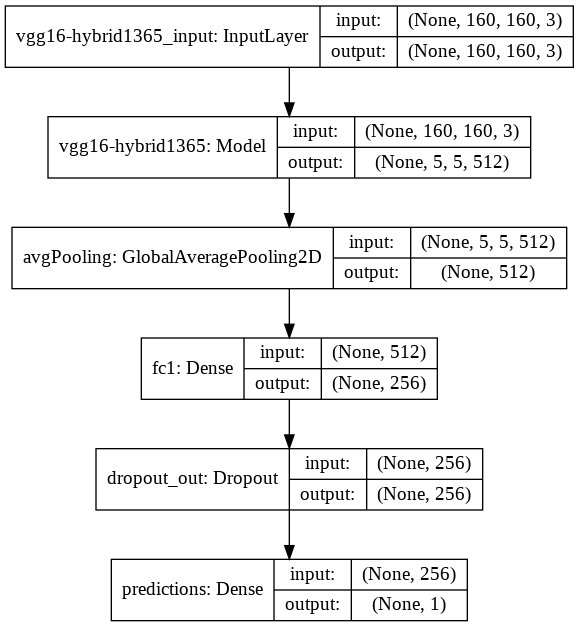

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=True,to_file='/content/models.png')

In [0]:
# %tensorboard --logdir logs

In [0]:
# tbc.TensorBoardColab(graph_path=logdir)

In [0]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
epochs=30
history_fine = model.fit_generator(train_generator,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=validation_generator,
                  validation_steps=validation_steps,
                  callbacks=[cb_checkpointer,cb_earlystopper])


Epoch 1/25
174/174 [==============================] - 1109s 6s/step - loss: 0.8957 - acc: 0.6829 - val_loss: 0.9100 - val_acc: 0.6727
Epoch 2/25
174/174 [==============================] - 95s 544ms/step - loss: 0.8092 - acc: 0.7449 - val_loss: 0.7983 - val_acc: 0.7389
Epoch 3/25
174/174 [==============================] - 95s 546ms/step - loss: 0.7551 - acc: 0.7944 - val_loss: 0.7903 - val_acc: 0.7731
Epoch 4/25
174/174 [==============================] - 95s 548ms/step - loss: 0.7202 - acc: 0.8182 - val_loss: 0.7973 - val_acc: 0.7269
Epoch 5/25
174/174 [==============================] - 95s 547ms/step - loss: 0.7248 - acc: 0.8118 - val_loss: 0.8879 - val_acc: 0.7123
Epoch 6/25
174/174 [==============================] - 95s 547ms/step - loss: 0.6863 - acc: 0.8303 - val_loss: 0.7195 - val_acc: 0.7808
Epoch 7/25
174/174 [==============================] - 95s 547ms/step - loss: 0.6720 - acc: 0.8371 - val_loss: 0.7838 - val_acc: 0.7731
Epoch 8/25
174/174 [==============================] - 95

In [0]:
acc = history_fine.history['acc']
val_acc = history_fine.history['val_acc']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

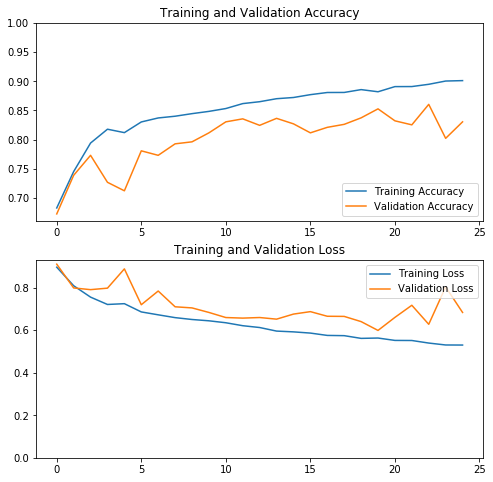

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
# plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,max(plt.ylim())])
# plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## plot confusion matrix

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
#Confution Matrix and Classification Report
threshold = 0.50
batch_size = 16
Y_pred = model.predict_generator(test_gen, test_gen.n // batch_size+1,workers=4,verbose=1)
y_pred = np.where(Y_pred > threshold, 1,0)
print('Classification Report')
target_names = ['nonresidential', 'residential']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

40/40 [==============================] - 5s 131ms/step
Classification Report
                precision    recall  f1-score   support

nonresidential       0.70      0.29      0.41       156
   residential       0.80      0.96      0.87       471

      accuracy                           0.79       627
     macro avg       0.75      0.62      0.64       627
  weighted avg       0.78      0.79      0.76       627



In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
#Confution Matrix and Classification Report
# threshold = 0.55
batch_size=16
Y_pred = model.predict_generator(test_gen, test_gen.n // batch_size+1,workers=4,verbose=1)
# y_pred = np.where(Y_pred > threshold, 1,0)
target_names = ['nonresidential', 'residential']
# print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

40/40 [==============================] - 5s 130ms/step


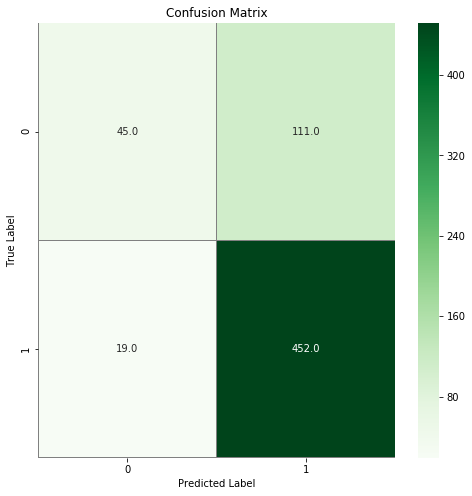

In [0]:
confusion_mtx = confusion_matrix(test_gen.classes, y_pred) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

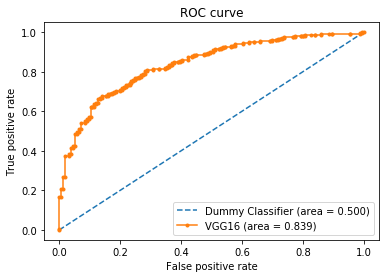

In [0]:
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve,f1_score,average_precision_score
from matplotlib import pyplot as plt
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, Y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], linestyle='--',label='Dummy Classifier (area = 0.500)')
plt.plot(fpr_keras, tpr_keras, label='VGG16 (area = {:.3f})'.format(auc_keras),marker='.')
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_gen.classes, Y_pred)
# calculate F1 score
f1 = f1_score(test_gen.classes, y_pred)
# calculate precision-recall AUC
rp_auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_gen.classes, Y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, rp_auc, ap))


f1=0.874 auc=0.939 ap=0.940


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.94')

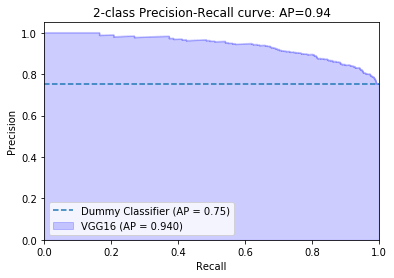

In [0]:
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve,f1_score,average_precision_score
from matplotlib import pyplot as plt
precision, recall, _ = precision_recall_curve(test_gen.classes, Y_pred)
average_precision = average_precision_score(test_gen.classes, Y_pred)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b',label='VGG16 (AP = {:.3f})'.format(average_precision))
plt.plot([0, 1], [0.75,0.75], linestyle='--',label='Dummy Classifier (AP = 0.75)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
                                    average_precision))

# Save the model

In [0]:
!cp -r /content/models gdrive/My\ Drive/MScthesis

## Load the model

In [0]:
from keras.models import load_model
model=load_model('/content/gdrive/My Drive/MScthesis/models/VGG16-0.6274-0.8604.h5')

W0830 10:02:09.528175 139671222798208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 10:02:09.604652 139671222798208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 10:02:09.665634 139671222798208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0830 10:02:10.182943 139671222798208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 10:02:10.184309 139671222798208 deprecation_wrapp

In [0]:
test_dir='/content/gdrive/My Drive/MScthesis/test/'
# Directory with our test non-residential pictures
test_nonresidential_dir = os.path.join(test_dir, 'nonresidential')
print ('Total test non-residential images:', len(os.listdir(test_nonresidential_dir)))

# Directory with our test residential pictures
test_residential_dir = os.path.join(test_dir, 'residential')
print ('Total test residential images:', len(os.listdir(test_residential_dir)))

Total test non-residential images: 156
Total test residential images: 471


In [0]:
image_size = 160
batch_size=16
test_idg = ImageDataGenerator(rescale=1./255)
test_gen = test_idg.flow_from_directory(
    '/content/gdrive/My Drive/MScthesis/test/',
    target_size=(image_size, image_size),
    batch_size = 16,
    shuffle = False,
    class_mode='binary',
    seed = 123
)
len(test_gen.filenames)

Found 627 images belonging to 2 classes.


627

In [0]:
test_steps = test_gen.n // batch_size
loss, acc = model.evaluate_generator(test_gen, steps = test_steps, workers = 4, verbose=1)

39/39 [==============================] - 4s 110ms/step


In [0]:
acc,loss

(0.7916666666666666, 0.7329344168687478)

In [0]:
import scipy
from scipy import ndimage
import PIL
import imageio
import os
import numpy as np
data_dir = '/content/gdrive/My Drive/MScthesis/train/nonresidential/'
imgs = os.listdir(data_dir)
num = len(imgs)
for i in range(num):
  im=imageio.imread(data_dir+imgs[i])
  im=im.astype('int32')
  dx = ndimage.sobel(im, 1)  # horizontal derivative
  dy = ndimage.sobel(im, 0)  # vertical derivative
  mag = np.hypot(dx, dy)  # magnitude
  mag *= 255.0 / np.max(mag)  # normalize (Q&D)
  imageio.imwrite(data_dir+"sobel_"+imgs[i], mag)
  print('save '+str(i))

save 0


save 1


save 2


save 3


save 4


save 5


save 6


save 7


save 8


save 9


save 10


save 11


save 12


save 13


save 14


save 15


save 16


save 17


save 18


save 19


save 20


save 21


save 22


save 23


save 24


save 25


save 26


save 27


save 28


save 29


save 30


save 31


save 32


save 33


save 34


save 35


save 36


save 37


save 38


save 39


save 40


save 41


save 42


save 43


save 44


save 45


save 46


save 47


save 48


save 49


save 50


save 51


save 52


save 53


save 54


save 55


save 56


save 57


save 58


save 59


save 60


save 61


save 62


save 63


save 64


save 65


save 66


save 67


save 68


save 69


save 70


save 71


save 72


save 73


save 74


save 75


save 76


save 77


save 78


save 79


save 80


save 81


save 82


save 83


save 84


save 85


save 86


save 87


save 88


save 89


save 90


save 91


save 92


save 93


save 94


save 95


save 96


save 97


save 98


save 99


save 100


save 101


save 102


save 103


save 104


save 105


save 106


save 107


save 108


save 109


save 110


save 111


save 112


save 113


save 114


save 115


save 116


save 117


save 118


save 119


save 120


save 121


save 122


save 123


save 124


save 125


save 126


save 127


save 128


save 129


save 130


save 131


save 132


save 133


save 134


save 135


save 136


save 137


save 138


save 139


save 140


save 141


save 142


save 143


save 144


save 145


save 146


save 147


save 148


save 149


save 150


save 151


save 152


save 153


save 154


save 155


save 156


save 157


save 158


save 159


save 160


save 161


save 162


save 163


save 164


save 165


save 166


save 167


save 168


save 169


save 170


save 171


save 172


save 173


save 174


save 175


save 176


save 177


save 178


save 179


save 180


save 181


save 182


save 183


save 184


save 185


save 186


save 187


save 188


save 189


save 190


save 191


save 192


save 193


save 194


save 195


save 196


save 197


save 198


save 199


save 200


save 201


save 202


save 203


save 204


save 205


save 206


save 207


save 208


save 209


save 210


save 211


save 212


save 213


save 214


save 215


save 216


save 217


save 218


save 219


save 220


save 221


save 222


save 223


save 224


save 225


save 226


save 227


save 228


save 229


save 230


save 231


save 232


save 233


save 234


save 235


save 236


save 237


save 238


save 239


save 240


save 241


save 242


save 243


save 244


save 245


save 246


save 247


save 248


save 249


save 250


save 251


save 252


save 253


save 254


save 255


save 256


save 257


save 258


save 259


save 260


save 261


save 262


save 263


save 264


save 265


save 266


save 267


save 268


save 269


save 270


save 271


save 272


save 273


save 274


save 275


save 276


save 277


save 278


save 279


save 280


save 281


save 282


save 283


save 284


save 285


save 286


save 287


save 288


save 289


save 290


save 291


save 292


save 293


save 294


save 295


save 296


save 297


save 298


save 299


save 300


save 301


save 302


save 303


save 304


save 305


save 306


save 307


save 308


save 309


save 310


save 311


save 312


save 313


save 314


save 315


save 316


save 317


save 318


save 319


save 320


save 321


save 322


save 323


save 324


save 325


save 326


save 327


save 328


save 329


save 330


save 331


save 332


save 333


save 334


save 335


save 336


save 337


save 338


save 339


save 340


save 341


save 342


save 343


save 344


save 345


save 346


save 347


save 348


save 349


save 350


save 351


save 352


save 353


save 354


save 355


save 356


save 357


save 358


save 359


save 360


save 361


save 362


save 363


save 364


save 365


save 366


save 367


save 368


save 369


save 370


save 371


save 372


save 373


save 374


save 375


save 376


save 377


save 378


save 379


save 380


save 381


save 382


save 383


save 384


save 385


save 386


save 387


save 388


save 389


save 390


save 391


save 392


save 393


save 394


save 395


save 396


save 397


save 398


save 399


save 400


save 401


save 402


save 403


save 404


save 405


save 406


save 407


save 408


save 409


save 410


save 411


save 412


save 413


save 414


save 415


save 416


save 417


save 418


save 419


save 420


save 421


save 422


save 423


save 424


save 425


save 426


save 427


save 428


save 429


save 430


save 431


save 432


save 433


save 434


save 435


save 436


save 437


save 438


save 439


save 440


save 441


save 442


save 443


save 444


save 445


save 446


save 447


save 448


save 449


save 450


save 451


save 452


save 453


save 454


save 455


save 456


save 457


save 458


save 459


save 460


save 461


save 462


save 463


save 464


save 465


save 466


save 467


save 468


save 469


save 470


save 471


save 472


save 473


save 474


save 475


save 476


save 477


save 478


save 479


save 480


save 481


save 482


save 483


save 484


save 485


save 486


save 487


save 488


save 489


save 490


save 491


save 492


save 493


save 494


save 495


save 496


save 497


save 498


save 499


save 500


save 501


save 502


save 503


save 504


save 505


save 506


save 507


save 508


save 509


save 510


save 511


save 512


save 513


save 514


save 515


save 516


save 517


save 518


save 519


save 520


save 521


save 522


save 523


save 524


save 525


save 526


save 527


save 528


save 529


save 530


save 531


save 532


save 533


save 534


save 535


save 536


save 537


save 538


save 539


save 540


save 541


save 542


save 543


save 544


save 545


save 546


save 547


save 548


save 549


save 550


save 551


save 552


save 553


save 554


save 555


save 556


save 557


save 558


save 559


save 560


save 561


save 562


save 563


save 564


save 565


save 566


save 567


save 568


save 569


save 570


save 571


save 572


save 573


save 574


save 575


save 576


save 577


save 578


save 579


save 580


save 581


save 582


save 583


save 584


save 585


save 586


save 587


save 588


save 589


save 590


save 591


save 592


save 593


save 594


save 595


save 596


save 597


save 598


save 599


save 600


save 601


save 602


save 603


save 604


save 605


save 606


save 607


save 608


save 609


save 610


save 611


save 612


save 613


save 614


save 615


save 616


save 617


save 618


save 619


save 620


save 621


save 622


save 623


save 624


save 625


save 626


save 627


save 628


save 629


save 630


save 631


save 632


save 633


save 634


save 635


save 636


save 637


save 638


save 639


save 640


save 641


save 642


save 643


save 644


save 645


save 646


save 647


save 648


save 649


save 650


save 651


save 652


save 653


save 654


save 655


save 656


save 657


save 658


save 659


save 660


save 661


save 662


save 663


save 664


save 665


save 666


save 667


save 668


save 669


save 670


save 671


save 672


save 673


save 674


save 675


save 676


save 677


save 678


save 679


save 680


save 681


save 682


save 683


save 684


save 685


save 686


save 687


save 688


save 689


save 690


save 691


save 692


save 693


save 694


save 695


save 696


save 697


save 698


save 699


save 700


save 701


save 702


save 703


save 704


save 705


save 706


save 707


save 708


save 709


save 710


save 711


save 712


save 713


save 714


save 715


save 716


save 717


save 718


save 719


save 720


save 721


save 722


save 723


save 724


save 725


save 726


save 727


save 728


save 729


save 730


save 731


save 732


save 733


save 734


save 735


save 736


save 737


save 738


save 739


save 740


save 741


save 742


save 743


save 744


save 745


save 746


save 747


save 748


save 749


save 750


save 751


save 752


save 753


save 754


save 755


save 756


save 757


save 758


save 759


save 760


save 761


save 762


save 763


save 764


save 765


save 766


save 767


save 768


save 769


save 770


save 771


save 772


save 773


save 774


save 775


save 776


save 777


save 778


save 779


save 780


save 781


save 782


save 783


save 784


save 785


save 786


save 787


save 788


save 789


save 790


save 791


save 792


save 793


save 794


save 795


save 796


save 797


save 798


save 799


save 800


save 801


save 802


save 803


save 804


save 805


save 806


save 807


save 808


save 809


save 810


save 811


save 812


save 813


save 814


save 815


save 816


save 817


save 818


save 819


save 820


save 821


save 822


save 823
